In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [55]:
# Load the dataset
class DiabetesDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.target[idx], dtype=torch.float32)


In [56]:
# Load dataset
data = pd.read_csv("/content/diabetes.csv")

In [57]:
# Split data into features and target
X = data.drop(columns=["Outcome"]).values
y = data["Outcome"].values


In [58]:

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [59]:
# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [60]:

# Create datasets
dataset_train = DiabetesDataset(X_train, y_train)
dataset_test = DiabetesDataset(X_test, y_test)

In [61]:

# Create dataloaders
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)

In [62]:

# Define the model
class DiabetesModel(nn.Module):
    def __init__(self, input_size):
        super(DiabetesModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x)

In [63]:
# Hyperparameters
input_size = X_train.shape[1]
learning_rate = 0.0001
num_epochs = 100

In [64]:
# Initialize model, loss, and optimizer
model = DiabetesModel(input_size)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)

In [65]:
# Training loop
training_accuracies = []
validation_accuracies = []
training_losses = []
validation_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, targets in train_loader:
        targets = targets.unsqueeze(1)  # Ensure targets have the correct shape
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        predicted_train = (outputs >= 0.5).float()
        total_train += targets.size(0)
        correct_train += (predicted_train == targets).sum().item()

    train_accuracy = correct_train / total_train
    training_accuracies.append(train_accuracy)
    training_losses.append(running_loss / len(train_loader))

    # Validation accuracy and loss
    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            targets = targets.unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

            predicted_val = (outputs >= 0.5).float()
            total_val += targets.size(0)
            correct_val += (predicted_val == targets).sum().item()

    val_accuracy = correct_val / total_val
    validation_accuracies.append(val_accuracy)
    validation_losses.append(val_loss / len(test_loader))

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")


Epoch [1/100], Loss: 0.7481, Train Accuracy: 0.4267, Validation Accuracy: 0.3571
Epoch [2/100], Loss: 0.7351, Train Accuracy: 0.4137, Validation Accuracy: 0.3896
Epoch [3/100], Loss: 0.7170, Train Accuracy: 0.5098, Validation Accuracy: 0.4675
Epoch [4/100], Loss: 0.6977, Train Accuracy: 0.5065, Validation Accuracy: 0.5065
Epoch [5/100], Loss: 0.6862, Train Accuracy: 0.5358, Validation Accuracy: 0.5649
Epoch [6/100], Loss: 0.6902, Train Accuracy: 0.5440, Validation Accuracy: 0.5909
Epoch [7/100], Loss: 0.6888, Train Accuracy: 0.5619, Validation Accuracy: 0.6299
Epoch [8/100], Loss: 0.6646, Train Accuracy: 0.5993, Validation Accuracy: 0.6494
Epoch [9/100], Loss: 0.6561, Train Accuracy: 0.6140, Validation Accuracy: 0.6558
Epoch [10/100], Loss: 0.6453, Train Accuracy: 0.6026, Validation Accuracy: 0.6883
Epoch [11/100], Loss: 0.6431, Train Accuracy: 0.6450, Validation Accuracy: 0.6948
Epoch [12/100], Loss: 0.6235, Train Accuracy: 0.6629, Validation Accuracy: 0.7273
Epoch [13/100], Loss: 0.6

In [66]:

# Final evaluation
print(f"Final Training Accuracy: {training_accuracies[-1]:.4f}")
print(f"Final Validation Accuracy: {validation_accuracies[-1]:.4f}")


Final Training Accuracy: 0.7671
Final Validation Accuracy: 0.7597


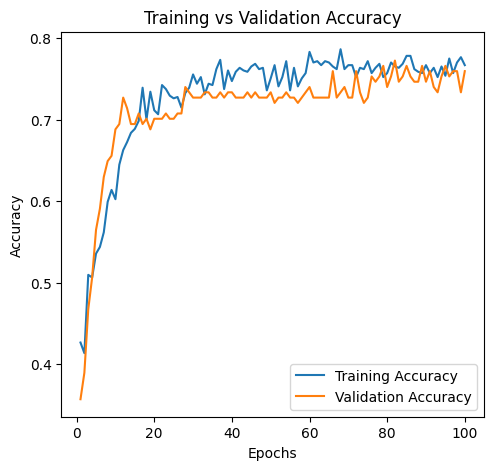

In [67]:
# Plotting
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), training_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()


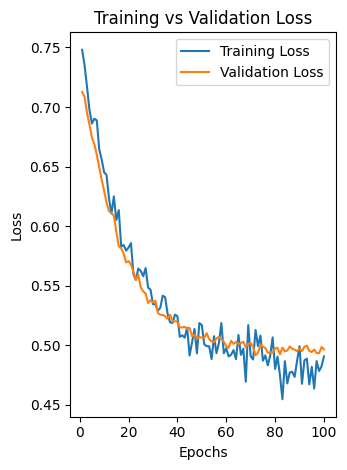

In [68]:

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), training_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [69]:
# Save the model
model_path = "diabetes_model.pth"
torch.save(model.state_dict(), model_path)


In [70]:
# Load the model
loaded_model = DiabetesModel(input_size)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()

<ipython-input-70-95aad177bf15>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(model_path))


DiabetesModel(
  (fc): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=32, out_features=1, bias=True)
    (13): Sigmoid()
  )
)

In [71]:
# Test the model with new data
new_data = [[6, 148, 72, 35, 0, 33.6, 0.627, 50]]  # Example data
new_data = scaler.transform(new_data)  # Scale the new data
new_data_tensor = torch.tensor(new_data, dtype=torch.float32)

In [76]:
with torch.no_grad():
    prediction = loaded_model(new_data_tensor)
    prediction = (prediction >= 0.5).float()
    if int(prediction.item()) == 1:
        print("The person is affected by diabetes.")
    else:
        print("The person is not affected by diabetes.")

The person is affected by diabetes.
